## Cloud masking

As we mentioned in the introduction, a critical step when preparing time series (either for time series analysis or mosaicking data). This notebook introduces a convenient function to use the qa_pixel bitmask band. 

This band is essentially a quality assurance band that NASA computes on the landsat data. It uses an algorithm called FMASK that uses the reflectance and the thermal bands to find clouds and clouds shadows, and encode flagged pixels in a bit mask, which we can use to remove unwanted observations for studying land processes.

In [104]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import matplotlib.pyplot as plt
import numpy as np

In [105]:
import stackstac
import rioxarray as rxr

In [106]:
import sys
sys.path.append('..')
import stackstac

from glance_utils.bad_images import remove_images
from glance_utils.landsat import mask_clouds

## Set the site from the landsat notebook example:

In [107]:
bbox=[-64.37891,-17.14158,-63.83207,-16.78130]
time_of_interest = "2022-01-01/2022-12-31"

In [108]:
## Open Planetary Hub Data Catalogue
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1',
                                        modifier=pc.sign_inplace,
                                       )
## Search params. Will return the full images which have at least partially cover your area_of_interest. Note that some may be covered in cloud. The image may be much larger than your AOI, as full image is returned.  
platforms=['landsat-8', 'landsat-9']
search = catalog.search(collections='landsat-c2-l2',
                                bbox =bbox,
                                datetime='2022-01-01/2023-01-01',
                                query={
                                    "eo:cloud_cover": {"lt":8},
                                    'platform': {'in': platforms},
                                    'landsat:collection_category': {'eq': 'T1'},
                                      }
                           )

collection = search.item_collection()

# Get list of returned images (Generator of items whose parent is this catalog)
items = list(search.items())

# Check how many items were returned - don't want too big!
print(f"Returned {len(items)} Items")

Returned 16 Items


### A convenient way to access the data

Below (Tutorial Continued) we go a bit more into detail of how this data looks and what is returned and how to play with it. There's some higher level functionality we can use to load data cubes in a consistent way:

In [109]:
# remove images that weren't ingested properly
collection = [item for item in collection if item.id not in remove_images]

In [110]:
stack = stackstac.stack(collection, 
                         resolution=30, 
                         bounds_latlon = bbox, 
                         fill_value=np.nan, 
                         epsg=5356 , # good coordinate ref. system for Bolivia 
                         chunksize='auto',
                        # resampling=Resampling.bilinear, 
                        dtype='float32',
                        
                       )

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [111]:
stack

<xarray.DataArray 'stackstac-ad60c162587c42948e103fafd55ba8f8' (time: 15,
                                                                band: 19,
                                                                y: 1382, x: 1981)>
dask.array<fetch_raster_window, shape=(15, 19, 1382, 1981), dtype=float32, chunksize=(3, 3, 1382, 1981), chunktype=numpy.ndarray>
Coordinates: (12/31)
  * time                         (time) datetime64[ns] 2022-02-10T14:17:09.70...
    id                           (time) <U31 'LC09_L2SP_231072_20220210_02_T1...
  * band                         (band) <U10 'qa' 'red' ... 'qa_aerosol'
  * x                            (x) float64 9.92e+05 9.92e+05 ... 1.051e+06
  * y                            (y) float64 8.139e+06 8.139e+06 ... 8.097e+06
    landsat:wrs_type             <U1 '2'
    ...                           ...
    raster:bands                 (band) object {'unit': 'kelvin', 'scale': 0....
    classification:bitfields     (band) object None ... [{'name': 'fill', 'le...
    common_name                  (band) object None 'red' 'blue' ... None None
    center_wavelength            (band) object None 0.65 0.48 ... None None None
    full_width_half_max          (band) object None 0.04 0.06 ... None None None
    epsg                         int64 5356
Attributes:
    spec:        RasterSpec(epsg=5356, bounds=(991950, 8097450, 1051380, 8138...
    crs:         epsg:5356
    transform:   | 30.00, 0.00, 991950.00|\n| 0.00,-30.00, 8138910.00|\n| 0.0...
    resolution:  30

right, so as you can see, this has 9 bands, which are

In [112]:
stack.band.values

array(['qa', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad',
       'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22',
       'coastal', 'qa_pixel', 'qa_radsat', 'qa_aerosol'], dtype='<U10')

we're interested in the qa_pixel, which has quality assurance info for each pixel (from the FMASK algorithm), the classification:bitfield coord gives the right values, but you don't need to look at this, you can just use the function below to mask out potential clouds and shadows:

In [113]:
def mask_clouds(landsat_da):
    mask_bitfields = [1, 2, 3, 4]  # dilated cloud, cirrus, cloud, cloud shadow
    bitmask = 0
    for field in mask_bitfields:
        bitmask |= 1 << field
    
    # select the bands that we're using
    t_bands = ['lwir11']
    r_bands = ['red','blue','green', 'nir08','swir16','swir22']

    bands = r_bands #+ t_bands 
    
    # select the bands and the qa_pixel 
    landsat_da = landsat_da.sel(band=bands+['qa_pixel'])
    
    # create the mask, 1 where clouds or shadows and 0 elsewhere
    qa = landsat_da.sel(band='qa_pixel').astype('uint16')
    cloudy_bitmask = qa & bitmask  # This is the subset of the qa_pixel pixels that we definitely don't want
    
    # Mask the images with their respective cloud mask, choosing only pixels where "cloud" isn't
    landsat_da = landsat_da.sel(band=bands).where(cloudy_bitmask == 0)
    return landsat_da

it might be easier to import it from the module:

In [114]:
from glance_utils.landsat import mask_clouds, LANDSAT_BANDS

 mask clouds and convert the collections to surface reflectance

In [115]:
LANDSAT_BANDS

['lwir11', 'red', 'blue', 'green', 'nir08', 'swir16', 'swir22']

In [116]:
stack

<xarray.DataArray 'stackstac-ad60c162587c42948e103fafd55ba8f8' (time: 15,
                                                                band: 19,
                                                                y: 1382, x: 1981)>
dask.array<fetch_raster_window, shape=(15, 19, 1382, 1981), dtype=float32, chunksize=(3, 3, 1382, 1981), chunktype=numpy.ndarray>
Coordinates: (12/31)
  * time                         (time) datetime64[ns] 2022-02-10T14:17:09.70...
    id                           (time) <U31 'LC09_L2SP_231072_20220210_02_T1...
  * band                         (band) <U10 'qa' 'red' ... 'qa_aerosol'
  * x                            (x) float64 9.92e+05 9.92e+05 ... 1.051e+06
  * y                            (y) float64 8.139e+06 8.139e+06 ... 8.097e+06
    landsat:wrs_type             <U1 '2'
    ...                           ...
    raster:bands                 (band) object {'unit': 'kelvin', 'scale': 0....
    classification:bitfields     (band) object None ... [{'name': 'fill', 'le...
    common_name                  (band) object None 'red' 'blue' ... None None
    center_wavelength            (band) object None 0.65 0.48 ... None None None
    full_width_half_max          (band) object None 0.04 0.06 ... None None None
    epsg                         int64 5356
Attributes:
    spec:        RasterSpec(epsg=5356, bounds=(991950, 8097450, 1051380, 8138...
    crs:         epsg:5356
    transform:   | 30.00, 0.00, 991950.00|\n| 0.00,-30.00, 8138910.00|\n| 0.0...
    resolution:  30

In [117]:
masked_stack = mask_clouds(stack).sel(band=['red','green','blue', 'nir08', 'swir16', 'swir22'])
stack = stack.sel(band=['red','green','blue', 'nir08', 'swir16', 'swir22'])

masked_stack = masked_stack * 0.0000275 - 0.2
stack =stack * 0.0000275 - 0.2

let's plot an image side by side to see what this did, it finds the biggest clouds and their shadows. Notice how some smaller clouds it misses (likely because the temperature band is at 100m 

In [118]:
test_img = masked_stack.isel(time=10)

In [123]:
test_img = test_img.where(test_img.isnull(), test_img *100 ) / 100

/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


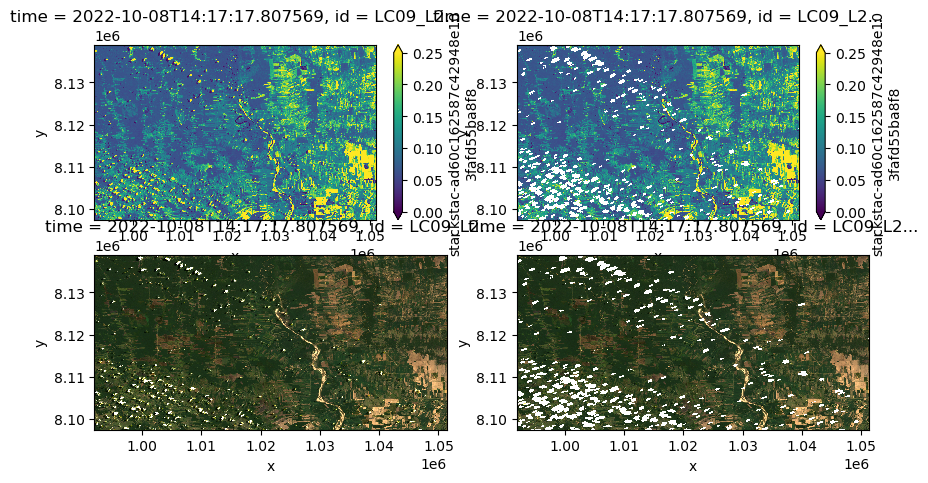

In [128]:
# plot short short wave infrared to better show the masking, and then rgb:
fig, ax = plt.subplots(2,2, figsize=(10,5))
ax = ax.flatten()
stack.isel(time=10).sel( band=['swir22'])[0].plot.imshow(vmin=0, vmax=0.25, ax=ax[0])
masked_stack.isel(time=10).sel( band=['swir22'])[0].plot.imshow(vmin=0, vmax=0.25, ax=ax[1])
stack.isel(time=10).sel( band=['red','green','blue']).plot.imshow(vmin=0, vmax=0.25, ax=ax[2])
masked_stack.isel(time=10).sel( band=['red','green','blue']).plot.imshow(vmin=0, vmax=0.25, ax=ax[3])
